In [5]:
# 1. Install pyflamegpu from the official wheelhouse
%pip install --extra-index-url https://whl.flamegpu.com/whl/cuda120/ pyflamegpu

# 2. Set the CUDA_PATH so FLAME GPU can find the compiler
import os
os.environ['CUDA_PATH'] = '/usr/local/cuda'

# 3. Verify installation
import pyflamegpu
print(f"FLAME GPU 2 version: {pyflamegpu.__version__}")

Looking in indexes: https://pypi.org/simple, https://whl.flamegpu.com/whl/cuda120/
FLAME GPU 2 version: 2.0.0rc4+cuda120


Running 50 steps of simulation...


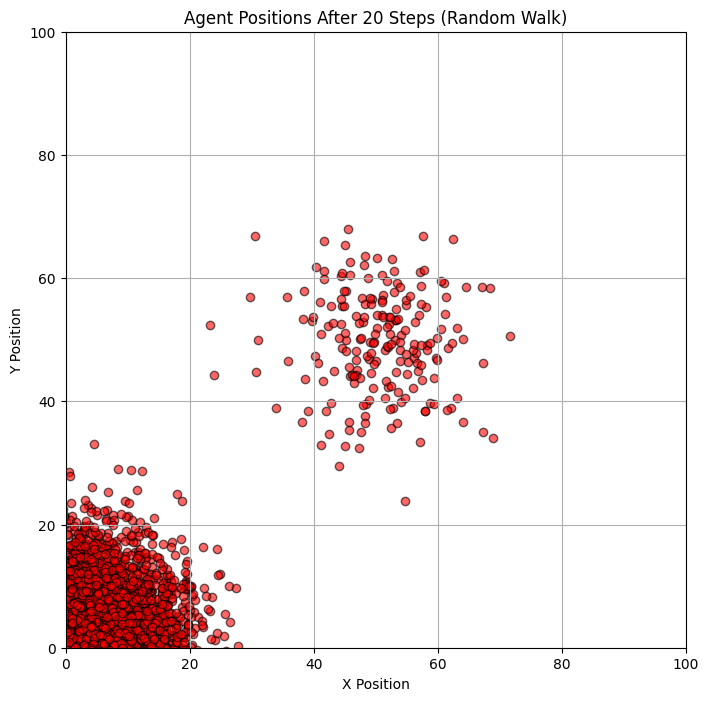

Visualization complete!


In [7]:
import pyflamegpu
import random
import matplotlib.pyplot as plt

# 1. Model Setup
model = pyflamegpu.ModelDescription("VisualDemo")
agent = model.newAgent("point")
agent.newVariableFloat("x")
agent.newVariableFloat("y")

# 2. Agent Logic: Simple Random Walk
# Agents will move by a random amount between -0.5 and 0.5 each step
step_func_code = """
FLAMEGPU_AGENT_FUNCTION(step_func, flamegpu::MessageNone, flamegpu::MessageNone) {
    float x = FLAMEGPU->getVariable<float>("x");
    float y = FLAMEGPU->getVariable<float>("y");
    
    // Simple jitter movement
    x += FLAMEGPU->random.uniform<float>(-0.5f, 0.5f);
    y += FLAMEGPU->random.uniform<float>(-0.5f, 0.5f);
    
    FLAMEGPU->setVariable<float>("x", x);
    FLAMEGPU->setVariable<float>("y", y);
    return flamegpu::ALIVE;
}
"""
func = agent.newRTCFunction("step_func", step_func_code)
model.newLayer().addAgentFunction(func)

# 3. Initialization
cuda_model = pyflamegpu.CUDASimulation(model)
population = pyflamegpu.AgentVector(agent, 10000) # 200 agents

for i in range(200):
    instance = population[i]
    # Start everyone in a tight cluster at the center
    instance.setVariableFloat("x", 50.0)
    instance.setVariableFloat("y", 50.0)

cuda_model.setPopulationData(population)

# 4. Run Simulation
print("Running 50 steps of simulation...")
cuda_model.step() # You can run this in a loop or increase step count
for _ in range(800):
    cuda_model.step()

# 5. Data Retrieval & Visualization
# Pull the final data from GPU back to the AgentVector
cuda_model.getPopulationData(population)

x_coords = [p.getVariableFloat("x") for p in population]
y_coords = [p.getVariableFloat("y") for p in population]

# Create the plot
plt.figure(figsize=(8, 8))
plt.scatter(x_coords, y_coords, color='red', alpha=0.6, edgecolors='black')
plt.title("Agent Positions After 20 Steps (Random Walk)")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.grid(True)
plt.show()

print("Visualization complete!")